In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# llm 설정
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [4]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together"""
    return a * b

In [5]:
# vector store 생성
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="real_estate_tax",
    persist_directory="./real_estate_tax_collection",
    embedding_function=embeddings
)

retriver = vector_store.as_retriever(search_kwargs={"k": 3})

In [6]:
from langchain_core.tools import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriver, 
    "real_estate_tax_retriever",
    "Real Estate Tax Retriever"
)

In [7]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search, retriever_tool]

tool_node = ToolNode(tool_list)
llm_with_tools = llm.bind_tools(tool_list)

In [8]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [9]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState):
    message = state['messages']
    summary = state['summary']

    if summary != '':
        message = [SystemMessage(content=f"Here is the summary of previous conversations: {summary}")] + message

    response = llm_with_tools.invoke(message)
    return {'messages': [response]}

In [10]:
from typing import Literal
from langchain_core.messages import content
from langgraph.types import Command, interrupt

def human_review(state: AgentState) -> Command[Literal['tools', 'agent']]:
    messages = state['messages']
    last_message = messages[-1]
    tool_call = last_message.tool_calls[-1]
    human_review = interrupt({
        'question': '이렇게 진행하면 될까요?',
        'tool_call': tool_call
    })
    review_action = human_review['action']
    review_data = human_review.get('data', None)
    
    if review_action == 'continue':
        # 에이전트의 판단이 맞다면, 도구를 사용하기 위해 아무것도 수정하지 않고 `tools` 노드로 이동합니다
        return Command(goto='tools')
    
    if review_action == 'update_args':
        # 도구를 더 효율적으로 사용하기 위해 AIMessage의 `tool_calls` 필드를 업데이트합니다
        updated_ai_message = {
            'id': last_message.id,
            'role': 'ai',
            'content': last_message.content,
            'tool_calls': [{
                'id': tool_call['id'],
                'name': tool_call['name'],
                'args': review_data
            }],
        }
        return Command(goto='tools', update={'messages': [updated_ai_message]})
    
    if review_action == 'update_tool':
        # 다른 도구를 사용하기 위해 `ToolMessage`를 업데이트합니다 
        updated_tool_message = {
            'tool_call_id': tool_call['id'],
            'name': tool_call['name'],
            'role': 'tool',
            'content': review_data
        }
        return Command(goto='agent', update={'messages': [updated_tool_message]})


In [11]:
def summarize_messages(state: AgentState):
    # state에서 메시지와 요약을 가져옵니다.
    messages = state['messages']
    summary = state['summary']
    
    # 요약 프롬프트를 생성합니다.
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    
    # 기존 요약이 있으면, 요약을 포함한 프롬프트를 생성합니다.
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}'''
    
    # LLM을 사용하여 요약을 생성합니다.
    summary = llm.invoke(summary_prompt)
    
    # 요약된 메시지를 반환합니다.
    return {'summary': summary.content}


In [12]:
from langchain_core.messages import RemoveMessage

def delete_message(state: MessagesState):
    current_message_list = state['messages']
    delete_message_list = [RemoveMessage(id=message.id) for message in current_message_list[:-3]]
    return {'messages': delete_message_list}

In [13]:
from typing import Literal

def should_continue(state: MessagesState) -> Literal['human_review', 'summarize_messages']:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'human_review'
    else:
        return 'summarize_messages'
        

In [14]:
graph_builder.add_node(agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(human_review)
graph_builder.add_node(delete_message)
graph_builder.add_node(summarize_messages)

In [15]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent', 
    should_continue,
    {
        'human_review': 'human_review',
        'summarize_messages': 'summarize_messages'
    }
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_message')
graph_builder.add_edge('delete_message', END)

In [16]:
from langgraph.checkpoint.memory import MemorySaver

checkpoint = MemorySaver()

graph = graph_builder.compile(
    checkpointer=checkpoint
)

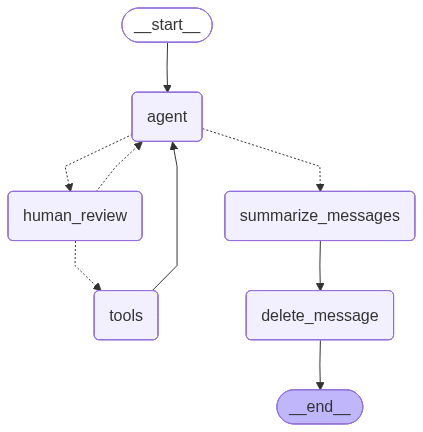

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': "real_estate_tax"
    }
}

messages = [HumanMessage(content="집이 15억일 때 종합부동산세를 계산해줄 수 있나요?")]

In [19]:
for chunk in graph.stream({'messages': messages, "summary": ""}, stream_mode='values', config=config):
    if 'messages' in chunk:
        chunk['messages'][-1].pretty_print()

================================ Human Message =================================

집이 15억일 때 종합부동산세를 계산해줄 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_R02EDyuakAW8PCVcuWTxDkk9)
 Call ID: call_R02EDyuakAW8PCVcuWTxDkk9
  Args:
    query: 종합부동산세 15억


In [20]:
for chunk in graph.stream(
    Command(resume={"action": "update_tool", "data": "웹 서치로 진행해주세요"}),
    config=config,
    stream_mode='updates'
):
    print(chunk)

{'human_review': {'messages': [{'tool_call_id': 'call_R02EDyuakAW8PCVcuWTxDkk9', 'name': 'real_estate_tax_retriever', 'role': 'tool', 'content': '웹 서치로 진행해주세요'}]}}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 217, 'total_tokens': 244, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CUl1jtP2uIysQvMcO2EXUmbuYrDAk', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--f640ec8f-e234-43cb-95ed-7d30884170b6-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '한국 종합부동산세 계산 15억'}, 'id': 'call_hKniUtAQUcxytRSp53Pd9LzV', 'type': 'tool_call'}], usage_metadata={

In [21]:
for chunk in graph.stream(
    Command(resume={"action": "continue"}),
    config=config,
    stream_mode='updates'
):
    print(chunk)

{'human_review': None}
{'tools': {'messages': [ToolMessage(content="July 19, 2025 - 종합부동산세(綜合不動産稅, 간단히 종부세)는 대한민국에서 국세청이 일정한 기준을 초과하는 토지 및 주택의 소유자에 대해 부과하는 세금 또는 그 제도를 말한다. 종부세는 「종합부동산세법」에 따라 부과되며, 고액의 ... Oct 19, 2025 · 한국 (韓國), 조선 (朝鮮), 남북한 (南北韓), 또는 코리아 (영어: Korea)는 동아시아 의 한반도 (조선반도)에 위치한 지역 또는 나라 를 지칭하는 말로, 오늘날에는 한반도와 그 부속 … June 23, 2025 - 종부세 계산기를 사용하면 내가 낼 종부세를 미리 계산할 수 있어요. KB스타뱅킹에서 종합부동산세 계산하기 6 days ago - 아파트 단독명의나 부부 ... 집계됐다. 실제 부부 공동명의로 15억 원 아파트를 2년째 보유 중인 A 씨가 있다고 할 때 이 사람이 올해 물어야 할 종부세는 한 푼도 없다 .... November 26, 2024 - 주택분 기본공제 '6→9억원', 1세대1주택자 '11→12억원' 상향 조정대상지역 2주택자 중과세율 폐지, 다주택자 세부담 상한율 '300%→150%' 윤석열 정부 출범 이후 최근 2년간 종합부동산세 적용 ...", name='duckduckgo_search', id='c4181d1b-78c0-4ecf-b171-1e7e6acd7175', tool_call_id='call_hKniUtAQUcxytRSp53Pd9LzV')]}}
{'agent': {'messages': [AIMessage(content='종합부동산세는 주택 및 토지의 공시가격에 따라 부과됩니다. 현재 15억 원의 주택에 대해 종합부동산세를 계산할 때, 몇 가지 주요 사항을 고려해야 합니다:\n\n1. **기본 공제:** 1세대 1주택자는 기본 공제 12억 원이 적용됩니다.\n2. **세율:** 주택의 공시가격에 따라 세율이 다르게 적용됩니다. 15억

In [22]:
# current_message_list = graph.get_state(config).values['messages']
# current_message_list

In [23]:
# question = "어디서는 1340만원이라는데?? 어떻게 된거야?"
# for chunk in graph.stream({'messages': HumanMessage(content=question)}, stream_mode='values', config=config):
#     chunk['messages'][-1].pretty_print()